# Query-by-committee

In [68]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import itertools as it
from tqdm.notebook import tqdm, trange
from collections import namedtuple
from modAL.models import Committee, ActiveLearner
from modAL.disagreement import vote_entropy_sampling, consensus_entropy_sampling, max_disagreement_sampling
from skorch import NeuralNetClassifier
from torchvision import datasets
from joblib import Parallel, delayed

seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

sns.set_theme(style="darkgrid")

ResultsRecord = namedtuple('ResultsRecord', ['estimator', 'query_id', 'score'])

In [69]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.fc = nn.Sequential(
            nn.Linear(64 * 8 * 8, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes),
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

In [70]:
def create_learner():
    net = NeuralNetClassifier(
        SimpleCNN,
        max_epochs=5,
        lr=0.001,
        optimizer=torch.optim.Adam,
        criterion=nn.CrossEntropyLoss,
        device="cuda" if torch.cuda.is_available() else "cpu",
        train_split=None,
        verbose=0,
        iterator_train__shuffle=True,
        module__num_classes=3,
        batch_size=64,
    )
    return ActiveLearner(
        estimator=net,
        query_strategy=vote_entropy_sampling,
        X_training=None,
        y_training=None,
    )

In [71]:
def load_filtered_CIFAR(
    selected_labels, num_train_per_class=200, num_test_per_class=50
):
    train = datasets.CIFAR100(root="./data", train=True, download=True)
    test = datasets.CIFAR100(root="./data", train=False, download=True)

    def filter_data(X, y, n):
        filtered_images = []
        filtered_labels = []

        for i, label in enumerate(selected_labels):
            indices = np.where(y == label)[0][:n]
            filtered_images.append(X[indices])
            filtered_labels.append(np.full(len(indices), i))

        X_filtered = np.concatenate(filtered_images, axis=0).astype(np.float32) / 255.0
        y_filtered = np.concatenate(filtered_labels, axis=0).astype(np.int64)

        # Reshape to (N, C, H, W) format
        X_filtered = X_filtered.transpose(0, 3, 1, 2)

        return X_filtered, y_filtered

    X_train, y_train = filter_data(
        train.data, np.array(train.targets), num_train_per_class
    )
    X_test, y_test = filter_data(test.data, np.array(test.targets), num_test_per_class)

    return X_train, y_train, X_test, y_test

In [72]:
def run_active_learning(
    i,
    method_name,
    method,
    committee_size,
    X_train,
    y_train,
    X_test,
    y_test,
    n_initial=10,
    n_queries=50,
    query_batch_size=1,
):
    initial_indices = np.random.choice(len(X_train), n_initial, replace=False)
    X_init, y_init = X_train[initial_indices], y_train[initial_indices]

    pool_indices = np.setdiff1d(np.arange(len(X_train)), initial_indices)
    X_pool, y_pool = X_train[pool_indices], y_train[pool_indices]

    committee_members = [create_learner() for _ in range(committee_size)]

    for learner in committee_members:
        learner.teach(X_init, y_init)

    committee = Committee(committee_members, method)

    performance_history = []
    for idx in (pbar := tqdm(range(n_queries),desc=f'Points {i} with {method_name}')):
        try:
            predictions = committee.predict(X_test)
            accuracy = np.mean(predictions == y_test)
            performance_history.append(ResultsRecord(method_name, idx, accuracy))

            pbar.set_description(f"Members: {committee_size}, Query {idx+1}, Accuracy: {accuracy:.4f}")

            query_idx, _ = committee.query(X_pool, n_instances=query_batch_size)

            committee.teach(X_pool[query_idx], y_pool[query_idx])

            mask = np.ones(len(X_pool), dtype=bool)
            mask[query_idx] = False
            X_pool, y_pool = X_pool[mask], y_pool[mask]

        except Exception as e:
            print(f"Error at iteration {idx}: {str(e)}")
            break

    return performance_history

In [73]:
from modAL.models.base import BaseCommittee
from modAL.utils.data import modALinput

def random_sampling(committee: BaseCommittee, X: modALinput,
                          n_instances: int = 1, random_tie_break=False,
                          **disagreement_measure_kwargs):
    return np.random.choice(len(X), n_instances)


In [74]:
# Experiments
selected_labels = [0, 1, 2]
n_classes = len(selected_labels)
n_initials = 10
n_queries = 50
committee_size = 4
n_repeats = 1
query_batch_size = 1
disagreement_methods = {
    "vote_entropy_sampling": vote_entropy_sampling, 
    "consensus_entropy_sampling": consensus_entropy_sampling, 
    "max_disagreement_sampling": max_disagreement_sampling,
    "random_sampling": random_sampling
    }

X_train, y_train, X_test, y_test = load_filtered_CIFAR(selected_labels)

Files already downloaded and verified
Files already downloaded and verified


In [65]:
results = Parallel(n_jobs=-1)(delayed(run_active_learning)(i,method_name, method, committee_size, X_train, y_train, X_test, y_test, n_queries=n_queries, query_batch_size=query_batch_size)
                    for i, (method_name,method) in it.product(range(n_repeats), disagreement_methods.items() ))

committee_results = [r for rs in results for r in rs]

In [66]:
df_results = pd.DataFrame(committee_results)
df_results.to_csv("data.csv")
df_results["estimator"].unique()

array(['vote_entropy_sampling', 'consensus_entropy_sampling',
       'max_disagreement_sampling', 'random_sampling'], dtype=object)

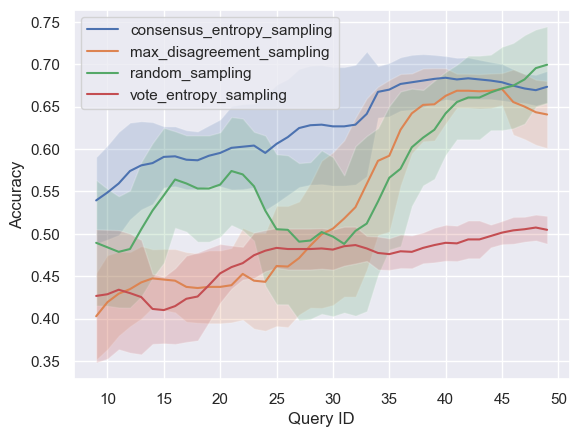

In [ ]:
df_results = pd.read_csv("data.csv")
fig, ax = plt.subplots()
for est, grp in df_results.groupby("estimator"):
    grp = grp.sort_values("query_id")
    mean = grp["score"].rolling(10).mean()
    std = grp["score"].rolling(10).std()
    ax.plot(grp["query_id"], mean, label=est)
    ax.fill_between(grp["query_id"], mean - std, mean + std, alpha=0.2)
ax.set_xlabel("Query ID")
ax.set_ylabel("Accuracy")
ax.legend()
plt.show()